# Aufgabe 4: Gauß-Filter
Der vorgestellte Mittelwertfilter bewirkt eine Glättung des Bildes, die zur Rauschunterdrückung verwendet werden kann.
Ein anderer Faltungsoperator mit demselben Zweck ist der Gauß-Filter $A_\text{Gauß} \in \mathbb{R}^{m \times m}$.
Dabei sind die Koeffizienten der Faltungsmaske gegeben durch
\begin{equation}
 A_\text{Gauß}(h,k) = \mathrm{e}^{-\frac{h^2+k^2}{2\sigma^2}}.
\end{equation}

Die Standardabweichung $\sigma$ wird hierbei in Abhängigkeit von der Fenstergröße üblicherweise auf $\sigma = \frac{m}{5}$ gesetzt.

Berechnen Sie für verschiedene Fenstergrößen (z.B. $m \in\{3, 5, 7\}$) die Koeffizienten des Gaußfilters!
Achten Sie dabei darauf, dass die Summe der Koeffizienten auf $1$ normiert wird, damit bei der Faltung das Bild insgesamt nicht heller oder dunkler wird!
Verwenden Sie die errechneten Gaußfilter als Ersatz für den Mittelwertfilter aus der vorherigen Teilaufgabe und vergleichen Sie die Ergebnisse!

## 0. Pfade, Pakete etc.

In [32]:
import glob
import urllib.request
import time

%matplotlib inline
import matplotlib.pyplot as plt

import PIL.Image
import numpy as np

In [33]:
image_filter = '../Bilder/*.jpg' # habe ich letzte mal schon hochgeladen.

## 1. Definition der Faltungsmaske
Definieren Sie hier zunächst die Parameter `m` und `sigma` des Filters. Berechnen Sie anschließend die Filtermaske `A_gauss` sowie (zum Vergleich) einen Mittelwertfilter derselben Größe!

In [34]:
def gaussian_kernel(size, sigma=None):
    if sigma is None:
        sigma = size / 5
    coords = np.arange(-(size // 2), size // 2 + 1, dtype=np.float32)
    xx, yy = np.meshgrid(coords, coords)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel.astype(np.float32)

m_values = (3, 5, 7, 20, 100)

gaussian_kernels = {}
average_kernels = {}

for m in m_values:
    sigma = m / 5
    gaussian_kernels[m] = gaussian_kernel(m, sigma)
    average_kernels[m] = np.full((m, m), 1 / (m * m), dtype=np.float32)

for m in m_values:
    print(f"m={m}: Gaußfilter Summe={gaussian_kernels[m].sum()}") #darauf sollte man ja achten

m=3: Gaußfilter Summe=1.0
m=5: Gaußfilter Summe=1.0
m=7: Gaußfilter Summe=0.9999999403953552
m=20: Gaußfilter Summe=0.9999999403953552
m=100: Gaußfilter Summe=1.0


## 2. Laden des Bildes

In [35]:
image_path = np.random.choice(glob.glob(image_filter))
image = np.asarray(PIL.Image.open(image_path).convert('L'))

Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [36]:
image = np.asarray(image, dtype=np.float32) / 255

## 3. Berechung der Faltung
Setzen Sie hier die Funktion `ex2_convolve` aus der vorherigen Aufgabe ein:

In [ ]:
def ex2_convolve(image, filter_mask):
    mask = np.asarray(filter_mask, dtype=np.float32)

    image = np.asarray(image, dtype=np.float32)

    m, n = mask.shape
    pad_y, pad_x = m // 2, n // 2
    padded = np.pad(image, ((pad_y, pad_y), (pad_x, pad_x)), mode="edge")
    windows = np.lib.stride_tricks.sliding_window_view(padded, mask.shape)
    return np.einsum("ijmn,mn->ij", windows, mask, optimize=True)

def ex2_convolve_naive(image, filter_mask):
    mask = np.asarray(filter_mask, dtype=np.float32)

    m, n = mask.shape
    pad_y, pad_x = m // 2, n // 2
    pad_width = ((pad_y, pad_y), (pad_x, pad_x))
    

    padded = np.pad(image, pad_width=pad_width, mode="edge")
    convolved_image = np.zeros_like(image, dtype=np.float32)

    rows, cols = image.shape[:2]
    for i in range(rows):
        for j in range(cols):
            window = padded[i : i + m, j : j + n]
            if image.ndim == 2:
                convolved_image[i, j] = np.sum(window * mask)
            else:
                convolved_image[i, j, :] = np.tensordot(window, mask, axes=([0, 1], [0, 1]))

    return convolved_image

Nun wird das gefaltete Bild mit Hilfe der Funktion berechnet:

In [ ]:
convolved_image_gauss = {}
convolved_image_avg = {}

for m in m_values:
    print("m="+str(m))
    if m > 20:
        %time convolved_image_gauss[m] = ex2_convolve_naive(image, gaussian_kernels[m])
    else:
        %time convolved_image_gauss[m] = ex2_convolve(image, gaussian_kernels[m]) # verbraucht zu viel Speicher, wegen des slide trick

for m in m_values:
    print("m="+str(m))
    if m > 20:
        %time convolved_image_avg[m] = ex2_convolve_naive(image, average_kernels[m])
    else:
        %time convolved_image_avg[m] = ex2_convolve(image, average_kernels[m])

m=3
CPU times: user 39.4 ms, sys: 83.8 ms, total: 123 ms
Wall time: 83.9 ms
m=5
CPU times: user 2.2 s, sys: 180 ms, total: 2.38 s
Wall time: 180 ms
m=7
CPU times: user 2.5 s, sys: 270 ms, total: 2.77 s
Wall time: 275 ms
m=20
CPU times: user 7.65 s, sys: 3.43 s, total: 11.1 s
Wall time: 3.63 s
m=100
CPU times: user 22.4 s, sys: 403 ms, total: 22.8 s
Wall time: 22 s
m=3
CPU times: user 99.6 ms, sys: 76.6 ms, total: 176 ms
Wall time: 82.8 ms
m=5
CPU times: user 2.21 s, sys: 166 ms, total: 2.38 s
Wall time: 180 ms
m=7
CPU times: user 2.56 s, sys: 256 ms, total: 2.82 s
Wall time: 278 ms
m=20
CPU times: user 7.19 s, sys: 3.01 s, total: 10.2 s
Wall time: 3.22 s
m=100
CPU times: user 21 s, sys: 515 ms, total: 21.6 s
Wall time: 18.5 s


## 4. Darstellung
Stellen Sie `image`, `convolved_image_avg` und `convolved_image_gauss` nebeneinander dar:

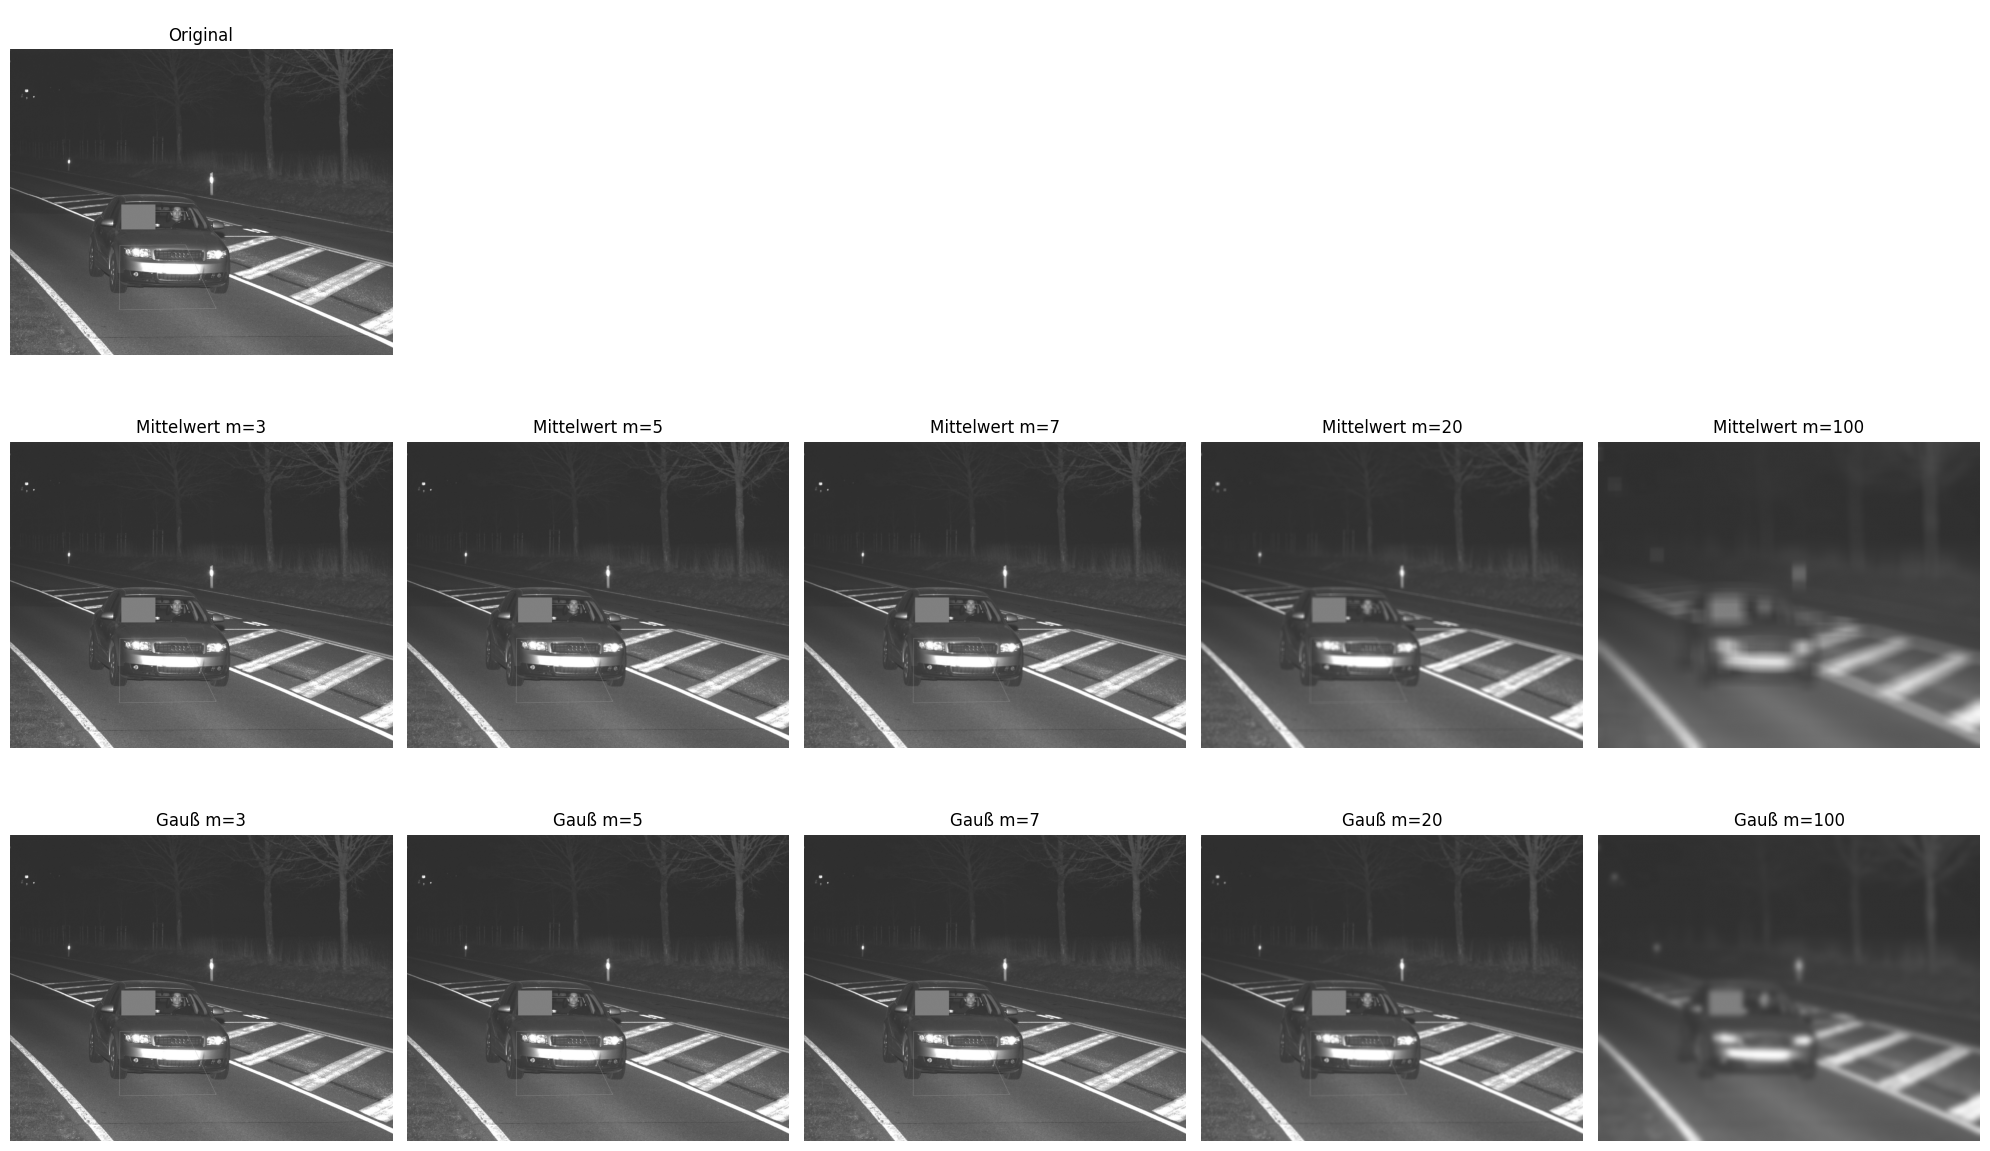

In [39]:
rows = [
    [(image, "Original")],
    [(convolved_image_avg[m], f"Mittelwert m={m}") for m in m_values],
    [(convolved_image_gauss[m], f"Gauß m={m}") for m in m_values],
]

n_rows = len(rows)
n_cols = max(len(row) for row in rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.atleast_2d(axes)

for row_idx, row in enumerate(rows):
    for col_idx, ax in enumerate(axes[row_idx]):
        if col_idx < len(row):
            img, title = row[col_idx]
            ax.imshow(img, vmin=0, vmax=1, cmap='gray')
            ax.set_title(title)
        ax.axis("off")

plt.tight_layout()
plt.show()